In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

#torchvision.transforms.Normalize(
#                                 (0.1307,), (0.3081,))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [22]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)
print(example_targets[1:10])

torch.Size([1000, 1, 16, 16])
torch.Size([1000])
tensor([4, 1, 7, 3, 9, 5, 5, 1, 2])


In [5]:
print(example_data[1][0])
print(example_data[1][0].view(-1,16*16))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7765, 1.0000, 1.0000,
         1.0000, 0.1137, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5529, 1.0000, 0.8863, 0.1137,
         1.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8863, 1.0000, 0.0000, 0.0000,
         0.7765, 1.0000, 0.1137, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5529, 0.0000, 0.0000,
         0.6667, 1.0000, 0.4471, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4471, 1.0000, 0.1137, 0.0000, 0.0000,
         1.0000, 1.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6667, 1.0000, 0.0000, 0.0000, 0.4471,
         1.0000, 1.0000, 0.7765, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7765, 1.0000, 0.0000, 0.0000, 0.7765,
         1.0000, 1.0000, 1.0000, 0.00

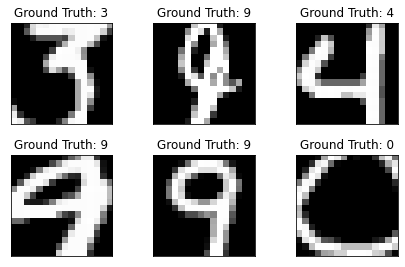

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(28*28, 16)
        self.fc1 = nn.Linear(16*16, 8)
        #self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(8, 10)

    def forward(self, x):
        x = x.view(-1,16*16)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
        #return torch.argmax(x)

In [36]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [37]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [38]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [39]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [40]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-35-d914daa2036d>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3348, Accuracy: 1058/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304919
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283166
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.295948
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.269189
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.188981
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.181474
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.192395
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.160404
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.134141
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.165720
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.158950
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.066383
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.071828
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.024808
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.951607
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.948059
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.924226
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.884079
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.842421
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.575513
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.538382
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.666324
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.316027
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.522375
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.498113
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.351359
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.789061
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.627599
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.586164
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.406997
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.380032
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.620651
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.484537
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.332312
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.599497
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.561336
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.412646
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.430517
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.542545


In [14]:
# print model's state_dict
print("model's state_dict")
for param_tensor in network.state_dict():
    print(param_tensor, "\t", network.state_dict()[param_tensor].size())
    print(network.state_dict()[param_tensor])

model's state_dict
fc1.weight 	 torch.Size([8, 256])
tensor([[-0.0626,  0.0485, -0.0006,  ...,  0.0224,  0.0051,  0.0434],
        [ 0.1667,  0.2019,  0.1502,  ...,  0.2417,  0.2129,  0.0817],
        [-0.0457, -0.0439, -0.0237,  ...,  0.0085, -0.0715, -0.0431],
        ...,
        [ 0.0373,  0.0114,  0.0380,  ...,  0.0834,  0.1180,  0.1187],
        [ 0.0135, -0.0090, -0.0727,  ..., -0.0897, -0.1196, -0.0666],
        [ 0.0320,  0.0438,  0.0891,  ...,  0.0579,  0.0855,  0.1291]])
fc1.bias 	 torch.Size([8])
tensor([-0.0584, -0.0844,  0.1476,  0.0842,  0.0808,  0.1961,  0.3523,  0.0644])
fc3.weight 	 torch.Size([10, 8])
tensor([[-0.2774, -0.1641, -0.7131,  0.8463, -0.7223, -0.4398,  0.6920,  0.7079],
        [-0.4782, -0.5926,  0.4943, -0.2513, -0.6075,  1.3375, -0.5672,  0.1815],
        [ 0.5671,  0.5567, -0.5974, -0.0513, -0.3223,  0.5959, -0.3678,  0.6789],
        [-0.3303,  1.4414,  0.4949, -0.2989, -0.6434, -0.3057, -0.0991, -0.2645],
        [-0.7042, -0.2126, -0.3400, -0.5201,

## TODO: store the test data in .txt file; store the parameters in .txt file

### Already get network.state_dict(), containing all parameters.
### Already get test_loader, can print test data in (1,256) (like example_data)

In [20]:
output = network(example_data[1][0])
print(output)
pred = output.data.max(1, keepdim=True)[1]
print(pred)
print(output.data.max(1, keepdim=True))

tensor([[-11.8112,  -2.0654,  -3.6321,  -3.8821,  -1.8789,  -6.3563,  -6.3382,
          -2.4117,  -1.7280,  -0.9098]], grad_fn=<LogSoftmaxBackward0>)
tensor([[9]])
torch.return_types.max(
values=tensor([[-0.9098]]),
indices=tensor([[9]]))


<ipython-input-8-759eb957afec>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
